# Inference Results Analysis

This notebook analyzes the Benchmark Results on ImageNet Test Dataset inferenced using JPDVT and visualizes the results. It computes:

- **Total images processed**
- **Overall Puzzle Accuracy** and **Patch Accuracy**
- **Unprocessed images** (by comparing with the dataset)
- A histogram of inference times
    
It also displays a few **good examples** (where the puzzle was solved perfectly) and **bad examples** (where the puzzle is not correct).

In [12]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Image, HTML

# For displaying images inline
%matplotlib inline

In [13]:
# --- Set parameters ---
## Path to the progress CSV generated during inference
LOGS_DIR = "/cluster/home/muhamhz/JPDVT/image_model/logs"
csv_path = os.path.join(LOGS_DIR, "inference_progress.csv")

## Path to the dataset (test images) to determine unprocessed images
DATA_DIR = "/cluster/home/muhamhz/data/imagenet/test"

## Path to the results folder (where combined images are stored)
# The inference script saves results in RESULTS_BASE_DIR/Grid{GRID_SIZE}
RESULTS_BASE_DIR = "/cluster/home/muhamhz/JPDVT/image_model/inference"
GRID_SIZE = 3
results_folder = os.path.join(RESULTS_BASE_DIR, f"Grid{GRID_SIZE}")

## Total number of patches per image (for a GRID_SIZE x GRID_SIZE puzzle)
total_patches = GRID_SIZE * GRID_SIZE

In [14]:
# --- Load the CSV ---
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print("Progress CSV loaded. Number of rows:", len(df))
    display(df.head())
else:
    print("No progress CSV found at", csv_path)

Progress CSV loaded. Number of rows: 100000


,filename,puzzle_correct,patch_matches,time_s
0,ILSVRC2012_test_00000001.JPEG,0,5,1.88
1,ILSVRC2012_test_00000004.JPEG,1,9,1.50
2,ILSVRC2012_test_00000003.JPEG,1,9,1.53
3,ILSVRC2012_test_00000002.JPEG,1,9,1.56
4,ILSVRC2012_test_00000005.JPEG,1,9,1.30


In [15]:
# --- Compute overall metrics ---
if os.path.exists(csv_path):
    total_processed = len(df)
    # Puzzle accuracy: average of puzzle_correct (assuming 1 means correct, 0 incorrect)
    puzzle_acc = df['puzzle_correct'].mean()
    # Patch accuracy: average patch_correct divided by total patches (we stored patch_matches per image)
    patch_acc = df['patch_matches'].sum() / (total_processed * total_patches)
    
    print(f"Total images processed: {total_processed}")
    print(f"Overall Puzzle Accuracy: {puzzle_acc:.4f}")
    print(f"Overall Patch Accuracy: {patch_acc:.4f}")
else:
    print("No CSV data available")

Total images processed: 100000
Overall Puzzle Accuracy: 0.6789
Overall Patch Accuracy: 0.8002


In [16]:
# --- Determine unprocessed images ---
dataset_images = glob.glob(os.path.join(DATA_DIR, '**', '*.*'), recursive=True)
dataset_images = [img for img in dataset_images if os.path.splitext(img)[1].lower() in ['.jpg', '.jpeg', '.png']]
total_dataset = len(dataset_images)

processed_files = set(df['filename'].tolist()) if os.path.exists(csv_path) else set()
unprocessed = [os.path.basename(img) for img in dataset_images if os.path.basename(img) not in processed_files]

print(f"Total images in dataset: {total_dataset}")
print(f"Unprocessed images: {len(unprocessed)}")

Total images in dataset: 100000
Unprocessed images: 0


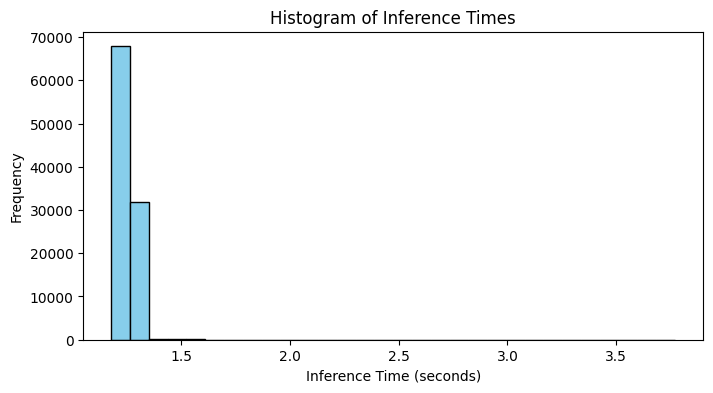

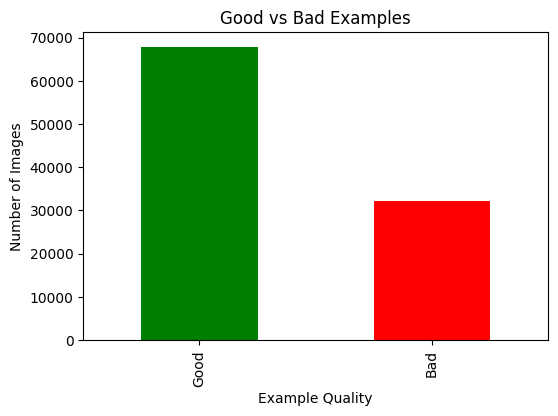

In [17]:
# --- Plot some graphs ---
# Histogram of inference times
if os.path.exists(csv_path):
    df['time_s'] = pd.to_numeric(df['time_s'])
    plt.figure(figsize=(8,4))
    plt.hist(df['time_s'], bins=30, color='skyblue', edgecolor='black')
    plt.xlabel('Inference Time (seconds)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Inference Times')
    plt.show()

# Bar chart of good vs bad examples
# Define good examples: puzzle_correct==1 and patch_matches==total_patches
if os.path.exists(csv_path):
    df['is_good'] = (df['puzzle_correct'] == 1) & (df['patch_matches'] == total_patches)
    counts = df['is_good'].value_counts()
    counts.index = counts.index.map({True: 'Good', False: 'Bad'})
    plt.figure(figsize=(6,4))
    counts.plot(kind='bar', color=['green', 'red'])
    plt.xlabel('Example Quality')
    plt.ylabel('Number of Images')
    plt.title('Good vs Bad Examples')
    plt.show()

In [18]:
# --- Additional Analytics: Total Inference Time and Histogram with Annotations ---

# Ensure the CSV is loaded
if 'df' not in globals():
    df = pd.read_csv(csv_path)

# Calculate total inference time
total_time_sec = df['time_s'].astype(float).sum()
total_time_min = total_time_sec / 60.0
total_time_hr = total_time_sec / 3600.0

print(f"Total inference time: {total_time_sec:.2f} seconds, {total_time_min:.2f} minutes, {total_time_hr:.2f} hours")

# Additional statistics
mean_time = df['time_s'].astype(float).mean()
median_time = df['time_s'].astype(float).median()
std_time = df['time_s'].astype(float).std()
min_time = df['time_s'].astype(float).min()
max_time = df['time_s'].astype(float).max()

print(f"Mean inference time per image: {mean_time:.2f} s")
print(f"Median inference time per image: {median_time:.2f} s")
print(f"Standard deviation: {std_time:.2f} s")
print(f"Minimum inference time: {min_time:.2f} s")
print(f"Maximum inference time: {max_time:.2f} s")


Total inference time: 125450.78 seconds, 2090.85 minutes, 34.85 hours
Mean inference time per image: 1.25 s
Median inference time per image: 1.26 s
Standard deviation: 0.03 s
Minimum inference time: 1.18 s
Maximum inference time: 3.77 s


Number of good examples: 67893
Found 67893 good combined images.


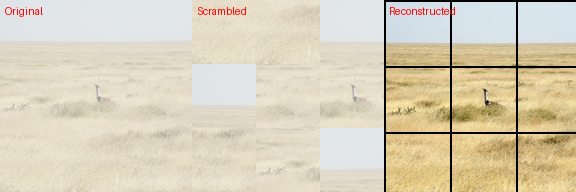

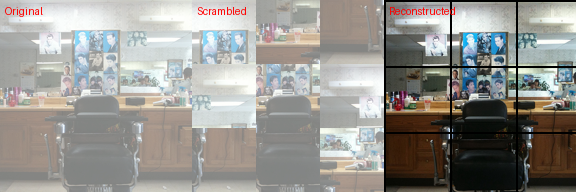

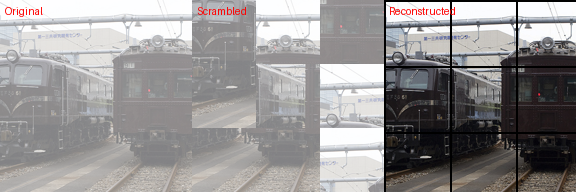

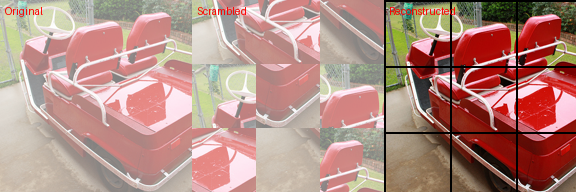

In [19]:
# --- Display some good examples ---
from IPython.display import display

good_df = df[df['puzzle_correct'] == 1]
good_df = good_df[good_df['patch_matches'] == total_patches]
print(f"Number of good examples: {len(good_df)}")

# Assume combined images are saved in RESULTS_BASE_DIR/Grid{GRID_SIZE}
combined_folder = os.path.join(RESULTS_BASE_DIR, f"Grid{GRID_SIZE}")
good_files = [os.path.join(combined_folder, f) for f in os.listdir(combined_folder) 
              if '_combined_' in f and 'pAcc=1' in f and 'patchAcc=1.00' in f]
print(f"Found {len(good_files)} good combined images.")

# Display first 4 good examples
for file in good_files[:4]:
    display(Image(filename=file))

Found 32107 bad combined images.


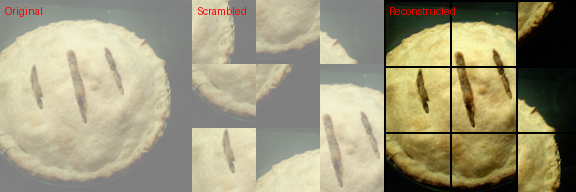

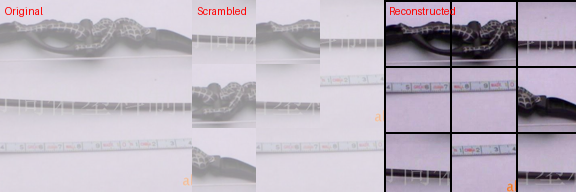

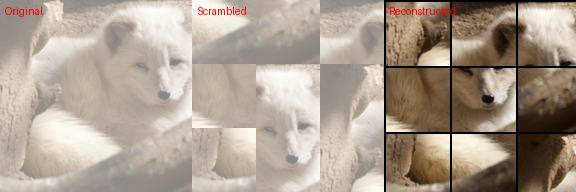

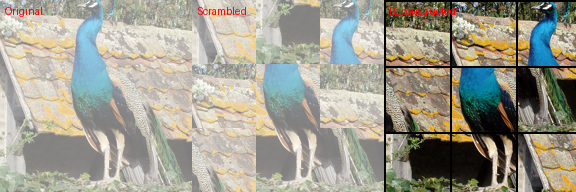

In [20]:
# --- Display some bad examples ---
bad_files = [os.path.join(combined_folder, f) for f in os.listdir(combined_folder) 
             if '_combined_' in f and (('pAcc=0' in f) or ('patchAcc=' in f and '1.00' not in f))]
print(f"Found {len(bad_files)} bad combined images.")

# Display first 4 bad examples
for file in bad_files[:4]:
    display(Image(filename=file))